To make sure this mimics the R code I'll make the same objects using `rpy2`. First lets install it - this may take a little time but you only need to run it once you start a new kaggle session

In [1]:
import subprocess
subprocess.run('conda install -c conda-forge r-base', shell=True)
!pip install rpy2

     |████████████████████████████████| 187 kB 404 kB/s eta 0:00:01
  Created wheel for rpy2: filename=rpy2-3.4.4-cp37-cp37m-linux_x86_64.whl size=308187 sha256=9d9f8049cf8ba35c6f8c198fa277be2fe0ff485f2775546ffca080b4fe36e3a4
  Stored in directory: /root/.cache/pip/wheels/e7/57/83/5a2a4b5c837d8318c94b0113206ddba813f6b2a54b63dfc386
Successfully built rpy2


In [2]:
# FOR RPY2
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri

Now lets install the `MASS` R package - not you don't need to understand any of the rpy2 stuff, this is just so this workbook is comparable to the R notebook.

In [6]:
# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('MASS',)

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

In [4]:
# FOR ML
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import numpy as np

1) Binary (2-class) classification

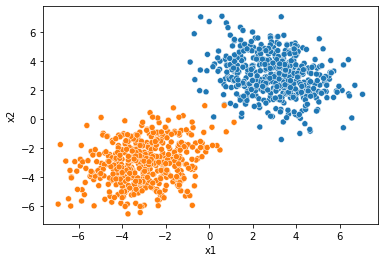

In [9]:
MASS = importr('MASS')

# Data (2 classes)
dat_r = robjects.r("""
set.seed(9)
dat = rbind( MASS::mvrnorm(n=500, mu=c(3,3),   Sigma=matrix(c(2,-1/2,-1/2,2), 2,2), empirical=TRUE),
             MASS::mvrnorm(n=500, mu=c(-3,-3), Sigma=matrix(c(2,1/2,1/2,2), 2,2), empirical=TRUE) )
dat = data.frame(dat, rep(0:1, each=500))
""")

# convert the R dataframe into pandas
with localconverter(robjects.default_converter + pandas2ri.converter):
    dat = robjects.conversion.rpy2py(dat_r)
    
dat.columns = ["x1", "x2", "y"]
sns.scatterplot(data = dat, x = "x1", y = "x2", hue= "y", legend = False)
plt.show()

1a) Binary classification as logistic regression

* 1-unit output layer representing probability of class "1"
* sigmoid activation
* binary_crossentropy loss
* Training output represented by numeric indicator
* Decision rule accepts class "1" if p>0.5

In [11]:
# Binary classification as logistic regression

batch = len(dat)     # Batch size is data size since all data is in memory

# Training inputs and outputs
X = dat[["x1", "x2"]]          # Usually you would scale to normalize inputs
Y = dat[["y"]]                 # Numeric indicator of output class

clear_session()  # clear the tensorflow session

# Model
model = Sequential()
model.add(Input(shape=(2)))                  # Shape must match number of inputs
model.add(Dense(1, activation = 'sigmoid'))  # 1-unit output layer for regression

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy')
model.fit(x=X, y=Y, epochs=200, batch_size=batch, verbose = 0)

p = model.predict(X)             # Fitted values (outputs predicted from training inputs)
confusion_matrix(Y, p.round())   # Threshold probability at 0.5. Note round(0.5) == 0

array([[493,   7],
       [  5, 495]])

1b) Binary classification as 2-class multiple classification

* 2-unit output layer representing probability of each mutually exclusive class
* softmax activation
* categorical_crossentropy loss
* Training outputs represented by 2 one-hot coded dummy variables
* Decision rule accepts output class with highest probability

In [12]:
# Training inputs and outputs
X = dat[["x1", "x2"]]                                      # Usually you would scale to normalize inputs
Y = OneHotEncoder(sparse=False).fit_transform(dat[["y"]])  # Numeric indicator of output class

clear_session()  # clear the tensorflow session

# Model
model = Sequential()
model.add(Input(shape=(2)))                 # Shape must match number of inputs
model.add(Dense(2, activation = 'softmax')) # Output units must match number of output classes

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy')
model.fit(x=X, y=Y, epochs=200, batch_size=batch, verbose = 0)

p = model.predict(X)                    # Fitted values (outputs predicted from training inputs)
confusion_matrix(np.argmax(Y, axis=1),  # Input class membership
                 np.argmax(p, axis=1))  # Output class membership

array([[499,   1],
       [  2, 498]])

 2) Multiple classification

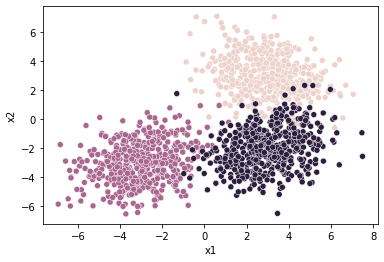

In [13]:
# Data (3 classes)

dat_r = robjects.r("""
set.seed(9)
dat = rbind(MASS::mvrnorm(n=500, mu=c(3,3),   Sigma=matrix(c(2,-1/2,-1/2,2), 2,2), empirical=TRUE),
            MASS::mvrnorm(n=500, mu=c(-3,-3), Sigma=matrix(c(2,1/2,1/2,2), 2,2), empirical=TRUE),
            MASS::mvrnorm(n=500, mu=c(3,-2), Sigma=matrix(c(2,1/2,1/2,2), 2,2), empirical=TRUE) )
dat = data.frame(dat, rep(0:2, each=500))
""")

# convert the R dataframe into pandas
with localconverter(robjects.default_converter + pandas2ri.converter):
    dat = robjects.conversion.rpy2py(dat_r)
    
dat.columns = ["x1", "x2", "y"]
sns.scatterplot(data = dat, x = "x1", y = "x2", hue= "y", legend = False)
plt.show()

In [14]:
# Multiple classification

batch = len(dat)     # Batch size is data size since all data is in memory

# Training inputs and outputs
X = dat[["x1", "x2"]].values                                      # Usually you would scale to normalize inputs
Y = OneHotEncoder(sparse=False).fit_transform(dat[["y"]].values)  # One-hot coded matrix (3 dummy variables). Numeric indicator y must start from 0

clear_session()  # clear the tensorflow session

# Model
model = Sequential()
model.add(Input(shape=(2)))                  # Shape must match number of inputs
model.add(Dense(3, activation = 'softmax'))  # Units must match number of output classes

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy')
model.fit(x=X, y=Y, epochs=200, batch_size=batch, verbose = 0)

p = model.predict(X)                    # Fitted values (outputs predicted from training inputs)
confusion_matrix(np.argmax(Y, axis=1),  # Input class membership
                 np.argmax(p, axis=1))  # Output class membership

array([[475,   0,  25],
       [  2, 490,   8],
       [ 19,   9, 472]])